In [1]:
import pandas as pd
import datetime as dt
from collections import defaultdict
import string

In [109]:
import numpy as np

In [2]:
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
infile = 'data/CB_RRT0211112.xlsx'

In [4]:
df = pd.read_excel(infile, sheet_name='Sheet1')

In [5]:
# preprocess event datetime
event_datetime_str = list(df['EventDate'].astype(str) + ' ' + df['IncidentTime'].astype(str))
event_datetime_str = [x.replace('1899-12-30 ', '') for x in event_datetime_str]
df['Event_DateTime'] = pd.to_datetime(event_datetime_str, format = '%Y-%m-%d %H:%M:%S')

In [6]:
df['Event_Year'] = df['Event_DateTime'].dt.year

In [7]:
df.shape[0], df['FileID'].nunique(), df['MRN'].nunique()

(15025, 15025, 9005)

In [8]:
# remove rows with at least one missing in the columns: MRN, Age
df = df.dropna(subset=['MRN', 'Age'])

In [9]:
df.shape[0], df['FileID'].nunique(), df['MRN'].nunique()

(14953, 14953, 9001)

In [10]:
df['Event_Year'].value_counts(sort=False)

2018    2423
2019    4719
2020    4106
2021    3705
Name: Event_Year, dtype: int64

In [11]:
# split into train/test
df_train = df[df.Event_Year != 2021]
df_test = df[df.Event_Year == 2021]

df_train.shape[0], df_test.shape[0]  # 75%:25% split

(11248, 3705)

In [12]:
# create corpora of notes
corpus_train = df_train['BriefFactualDescription']
corpus_test = df_test['BriefFactualDescription']

In [13]:
# instantiate the vectorizer object
# countvectorizer = CountVectorizer(analyzer='word', stop_words='english', ngram_range=(1,5))
tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words='english') #, ngram_range=(1,1))

# convert the documents into a matrix
tfidf_wm = tfidfvectorizer.fit_transform(corpus_train)

tfidf_wm.shape

(11248, 29460)

In [56]:
# retrieve the terms found in the corpora
tfidf_tokens = tfidfvectorizer.get_feature_names_out()

# create dataframe objects for neat display
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), 
                            index = df_train['FileID'], 
                            columns=tfidf_tokens)

## Run PCA

In [163]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# fit the model
pca_vecs = pca.fit_transform(tfidf_wm.toarray())

df_train.loc[:, 'PC1'] = pca_vecs[:, 0]
df_train.loc[:, 'PC2'] = pca_vecs[:, 1]

/var/folders/cq/fh2lg0p11nv1_7x21vz35f500000gq/T/ipykernel_88211/569189714.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'PC1'] = pca_vecs[:, 0]
/var/folders/cq/fh2lg0p11nv1_7x21vz35f500000gq/T/ipykernel_88211/569189714.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'PC2'] = pca_vecs[:, 1]


### Perform K-means clustering

In [177]:
# initialize kmeans 
n_cluster = 5
kmeans = KMeans(n_clusters=n_cluster, random_state=42) 

# fit the model
kmeans.fit(tfidf_wm) 

cluster = kmeans.labels_
df_train['cluster'] = cluster

cl2keywords = dict()
for i in range(n_cluster):
    # for each cluster, identify the top features in terms of the mean value
    df_cl = df_tfidfvect.loc[cluster == i]
    
    # reorder features(=columns) by descending order of the mean value
    df_cl = df_cl.reindex(df_cl.mean().sort_values(ascending=False).index, axis=1)
    
    # select the first 10 words
    cl2keywords[i] = str(i) + ': '  +','.join(list(df_cl.columns[:10]))
    

df_train['cluster_keywords'] = df_train['cluster'].map(cl2keywords)

/var/folders/cq/fh2lg0p11nv1_7x21vz35f500000gq/T/ipykernel_88211/302435776.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['cluster'] = cluster
/var/folders/cq/fh2lg0p11nv1_7x21vz35f500000gq/T/ipykernel_88211/302435776.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['cluster_keywords'] = df_train['cluster'].map(cl2keywords)


### Visualize the clustering

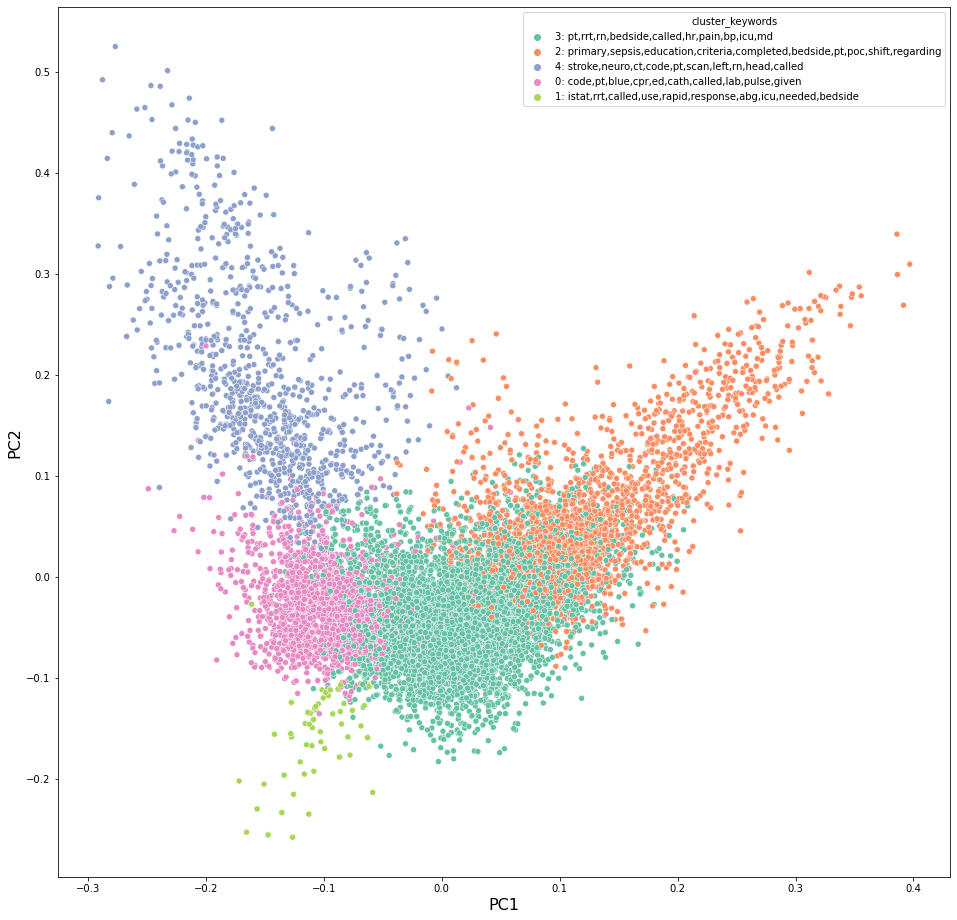

In [179]:
# set the image size
plt.figure(figsize=(16,16))

# set axes names
plt.xlabel("PC1", fontdict={"fontsize": 16})
plt.ylabel("PC2", fontdict={"fontsize": 16})

# draw a scatter plot
sns.scatterplot(data=df_train, x = 'PC1', y = 'PC2', hue='cluster_keywords', palette='Set2')
plt.show()

In [ ]:
df['SurviveEvent'].value_counts()

In [ ]:
df['SeverityLevel'].value_counts()

In [ ]:
df['SpecificEventType'].value_counts()

In [ ]:
df['AdmissionAgeGroup'].value_counts()

In [ ]:
df['Division'].value_counts().head(10)

In [ ]:
df['Event_DateTime'].dt.hour.value_counts()

In [ ]:
df['Event_DateTime'].dt.weekday.value_counts() # 0: Monday,..., 6: Sunday

In [ ]:
corpus = df['BriefFactualDescription']

In [ ]:
# 106K total words
#  53K after removing capitalization/punctuation
#  47K after stemming (=merging different inflections of words)
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
#stemmer = nltk.stem.porter.PorterStemmer()
for d in corpus:
    text = ''.join([c for c in d.lower() if not c in punctuation])
    unigram = text.split() # unigram
    bigram = [' '.join(x) for x in list(zip(unigram[:-1], unigram[1:]))] 
    trigram = [' '.join(x) for x in list(zip(unigram[:-2], unigram[1:-1]))]
    for w in unigram + bigram + trigram:
        #w = stemmer.stem(w)
        wordCount[w] += 1

print( len(wordCount) )

In [ ]:
# keep top 2000 most frequent words 
counts = [ (wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:2000]]

In [ ]:
words[:10]

In [ ]:
# term frequency
tf = defaultdict(int)
